In [1]:
from pathlib import Path
import itertools
from functools import reduce

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.mixture import GaussianMixture
from tqdm import tqdm


from lobib import DataLoader

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

In [2]:
def pl_select(condlist: list[pl.Expr], choicelist: list[pl.Expr]) -> pl.Expr:
    return reduce(
        lambda expr, cond_choice: expr.when(cond_choice[0]).then(cond_choice[1]),
        zip(condlist, choicelist),
        pl.when(condlist[0]).then(choicelist[0]),
    )

In [3]:
loader = DataLoader()

In [16]:
dt = dict()

tickers = ["AAL", "AMRX", "MSFT", "INTC", "KHC", "CSX"]
for ticker in tqdm(tickers, position=0, leave=True, colour="green"):
    info = loader.ticker_info(ticker)
    df = loader.load(
        ticker,
        start_date=info["date"].min(),
        end_date=info["date"].max(),
        schema="qr",
        eager=True,
    ).sort(["date", "ts_event"])
    df = df.filter(
        (
            pl.col("event_side")
            .replace({"A": 1, "B": -1})
            .cast(int)
            .mul(pl.col("event_queue_nbr"))
            >= 0
        )
    )
    df = df.with_columns(
        pl.when(pl.col("event_queue_nbr").lt(0))
        .then(pl.col("event_queue_nbr").sub(pl.col("best_bid_nbr")).sub(1))
        .otherwise(pl.col("event_queue_nbr").sub(pl.col("best_ask_nbr")).add(1))
        .alias("event_q")
    )
    df = df.filter(pl.col("event_q").abs().le(2))
    dt_ = df.select(pl.col("ts_event").diff().over("date").cast(int).alias("dt")).filter(pl.col("dt").gt(0))
    dt_ = dt_.with_columns(pl.col("dt").log10().alias("dt_log"))
    dt[ticker] = dt_["dt_log"]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.79s/it]


In [17]:
modes = {}
half_widths = {}

for ticker in tickers:
  data = dt[ticker].to_numpy()

  n_bins = min(500, int(np.sqrt(len(data))))
  counts, bins = np.histogram(data, bins=n_bins, density=True)
  bin_centers = (bins[:-1] + bins[1:]) / 2

  # Find mode
  mode_idx = np.argmax(counts)
  mode_val = bin_centers[mode_idx]
  modes[ticker] = mode_val

  # Find 50% threshold bounds
  mode_density = counts[mode_idx]
  threshold = mode_density * 0.5

  # Left bound
  left_idx = np.where(counts[:mode_idx] < threshold)[0]
  left_bound = bin_centers[left_idx[-1]] if len(left_idx) > 0 else bin_centers[0]

  # Right bound
  right_idx = np.where(counts[mode_idx:] < threshold)[0]
  right_bound = bin_centers[mode_idx + right_idx[0]] if len(right_idx) > 0 else bin_centers[-1]

  half_widths[ticker] = (left_bound, right_bound)


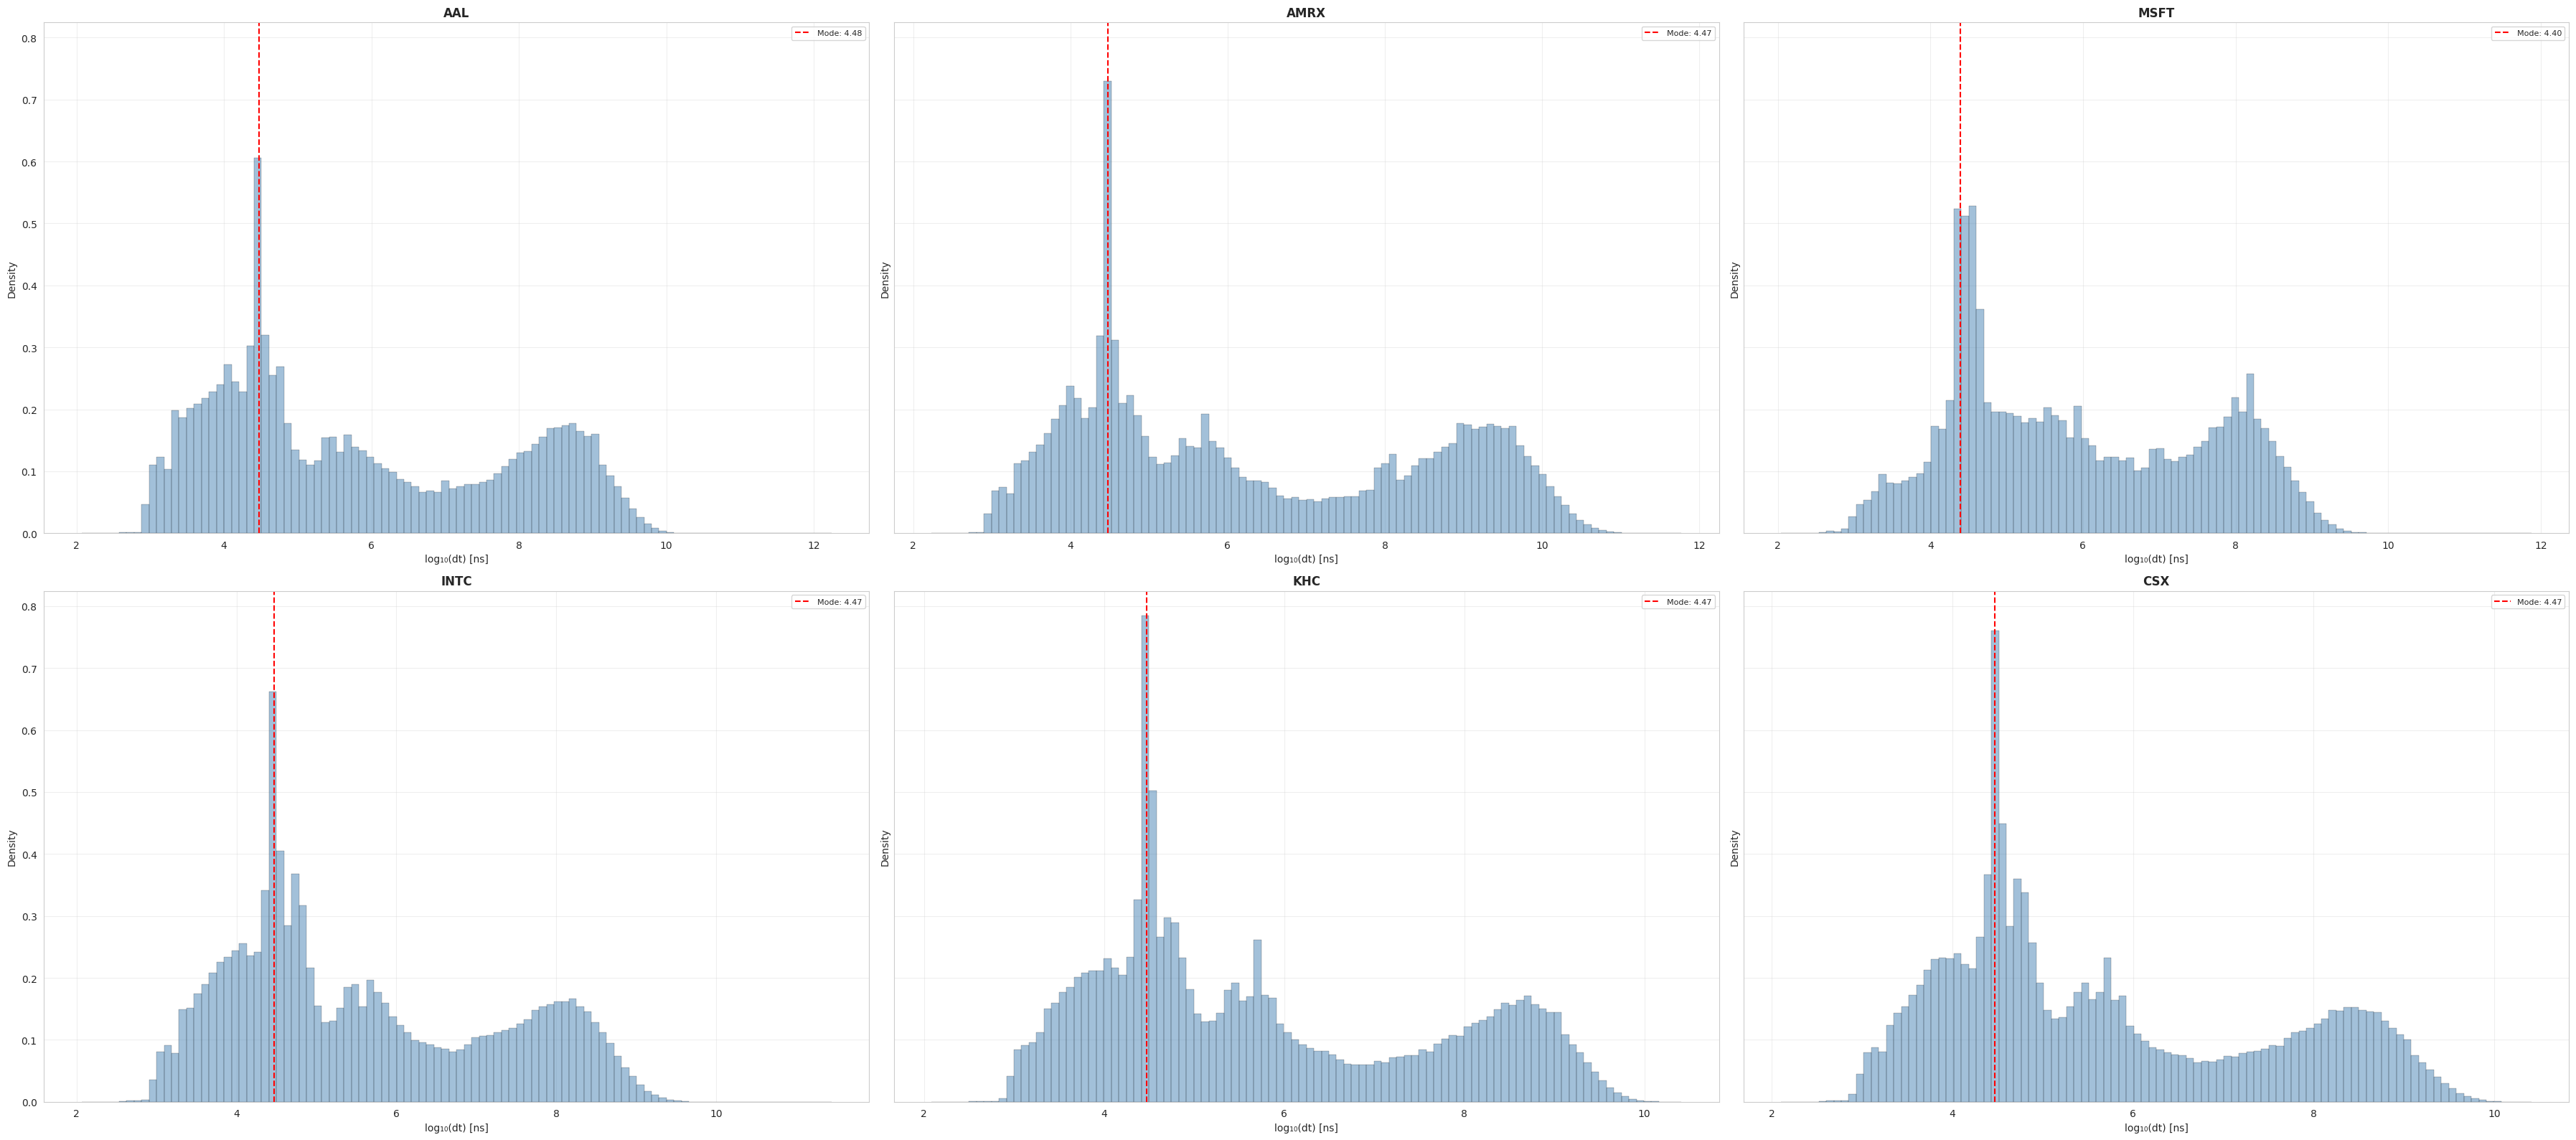

In [30]:
fig, axes = plt.subplots(2, len(tickers)//2, figsize=(6 * len(tickers), 16), sharey=True)
axes = axes.ravel()

for ax, ticker in zip(axes, tickers):
  data = dt[ticker].to_numpy()

  ax.hist(data, bins=100, density=True, alpha=0.5, color='steelblue', edgecolor='black', linewidth=0.3)
  ax.axvline(modes[ticker], color='red', linestyle='--', linewidth=1.5, label=f'Mode: {modes[ticker]:.2f}')

  ax.legend(fontsize=8)
  ax.set_xlabel("log₁₀(dt) [ns]")
  ax.set_ylabel("Density")
  ax.set_title(ticker, fontweight="bold")
  ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/dt_hist.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

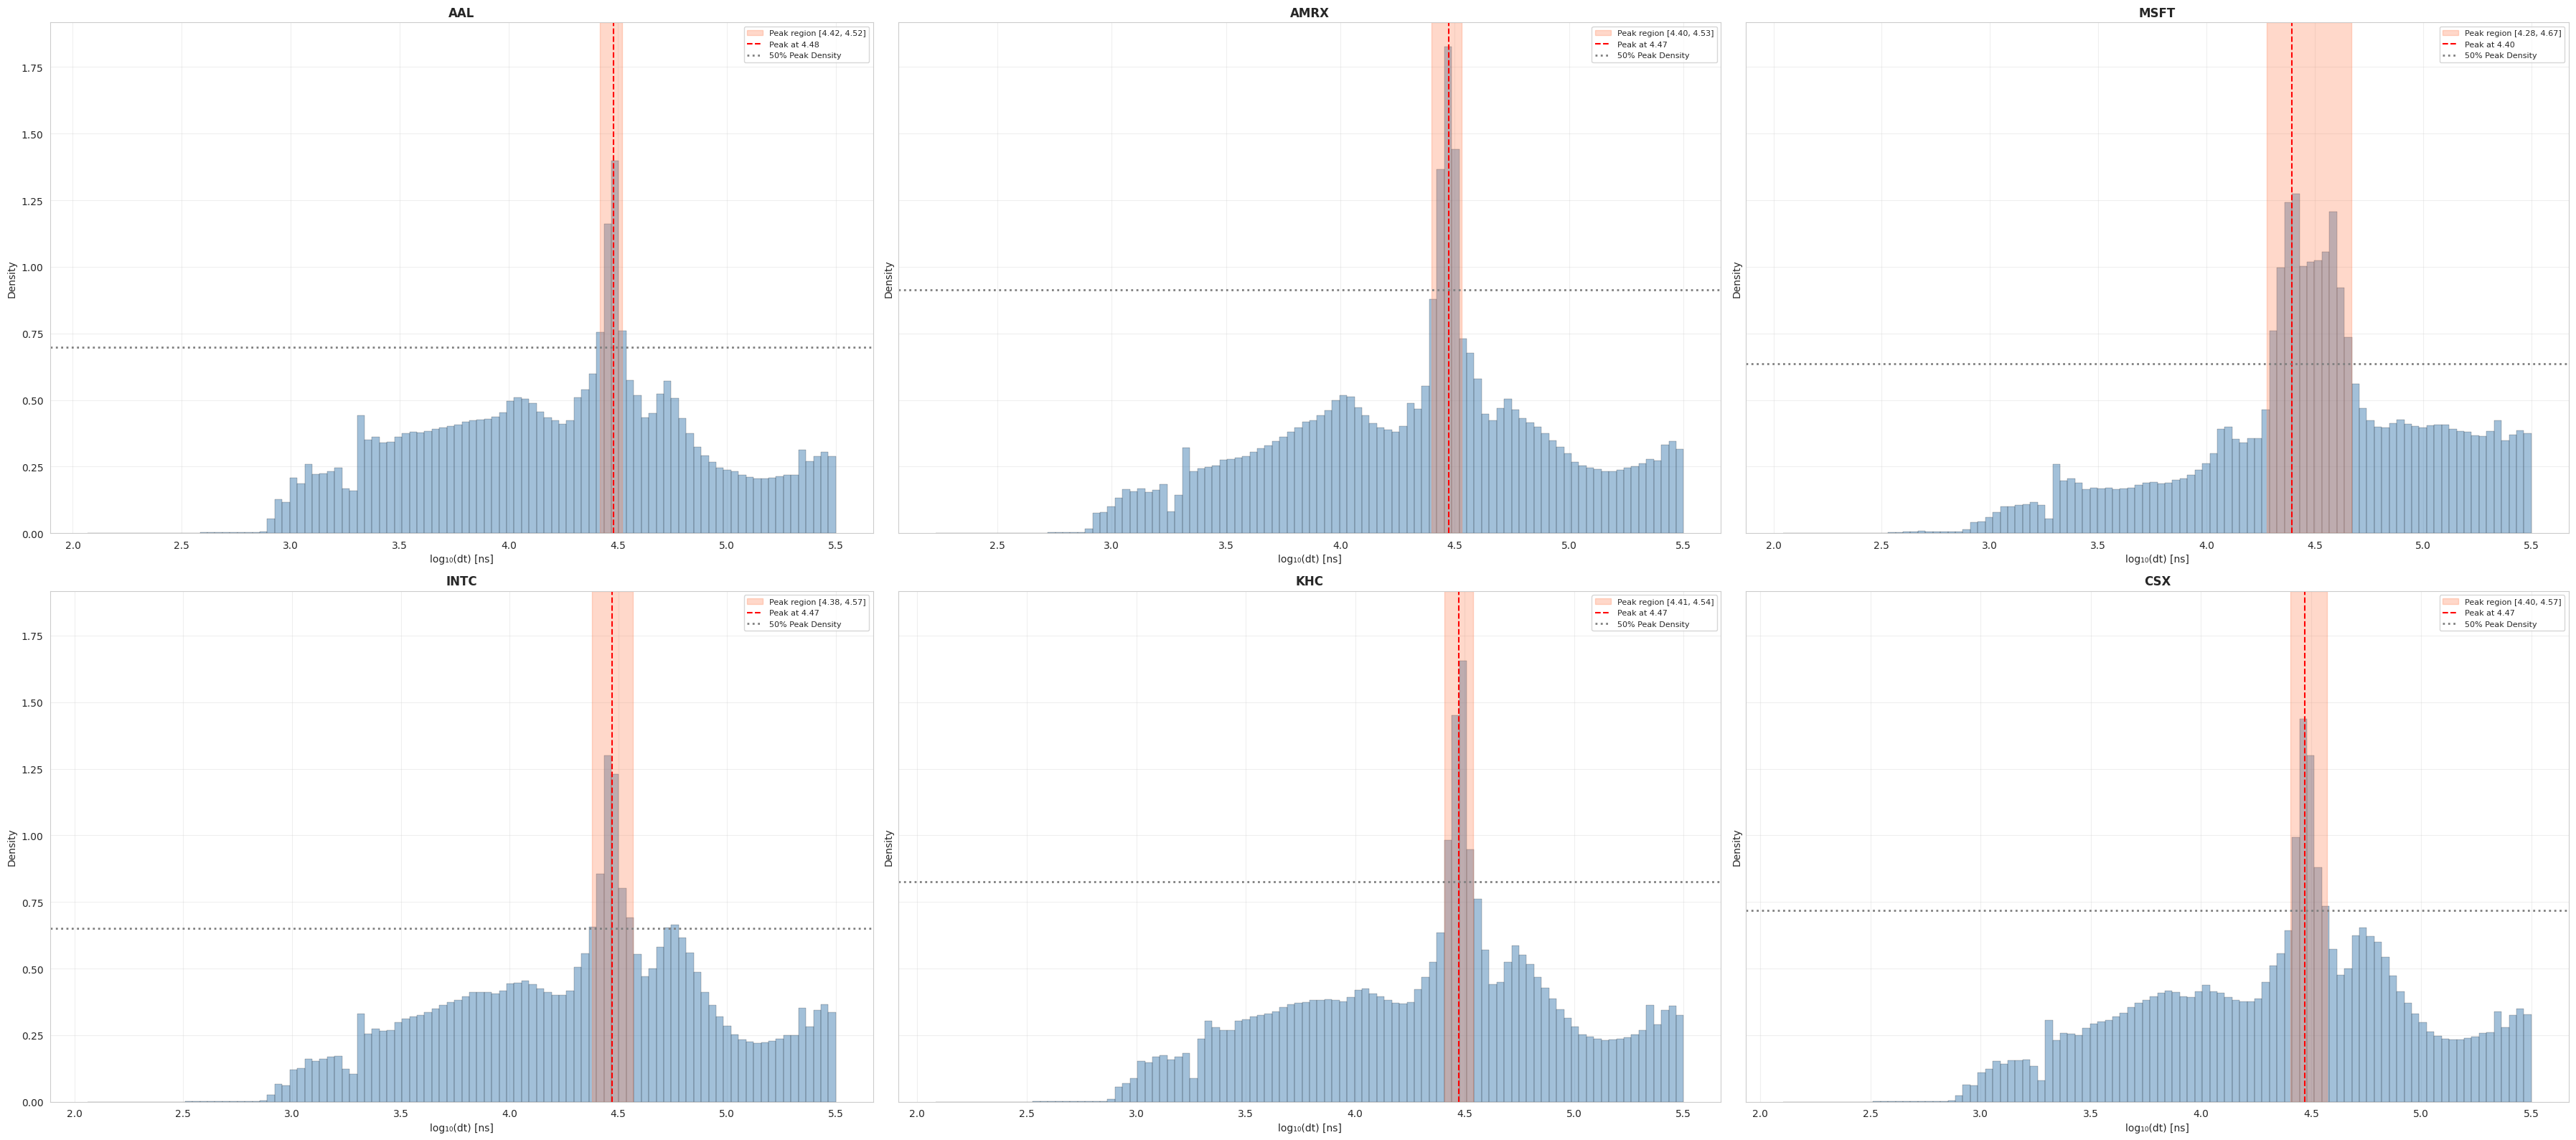

In [31]:
fig, axes = plt.subplots(2, len(tickers)//2, figsize=(6 * len(tickers), 16), sharey=True)
axes = axes.ravel()

for ax, ticker in zip(axes, tickers):
  data = dt[ticker].to_numpy()
  data_zoomed = data[data < 5.5]

  left_bound, right_bound = half_widths[ticker]
  mode_val = modes[ticker]

  # Get threshold density value
  counts, bins = np.histogram(data_zoomed, bins=100, density=True)
  bin_centers = (bins[:-1] + bins[1:]) / 2
  mode_idx = np.argmax(counts)
  threshold = counts[mode_idx] * 0.5

  ax.hist(data_zoomed, bins=100, density=True, alpha=0.5, color='steelblue', edgecolor='black', linewidth=0.3)
  ax.axvspan(left_bound, right_bound, alpha=0.3, color='coral', label=f'Peak region [{left_bound:.2f}, {right_bound:.2f}]')
  ax.axvline(mode_val, color='red', linestyle='--', linewidth=1.5, label=f'Peak at {mode_val:.2f}')
  ax.axhline(threshold, color='gray', linestyle=':', linewidth=2, label=f'50% Peak Density')

  ax.legend(fontsize=8)
  ax.set_xlabel("log₁₀(dt) [ns]")
  ax.set_ylabel("Density")
  ax.set_title(ticker, fontweight="bold")
  ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/dt_hist_zoomed.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [8]:
# pl.DataFrame({
#   "mu": [mu],
#   "sigma": [sigma],
#   "lower": [a],
#   "upper": [b]
# }).write_csv("../data/AAL2/delta_distrib.csv")

In [32]:
info = loader.ticker_info("AAL")
df = loader.load(
    "AAL",
    start_date=info["date"].min(),
    end_date=info["date"].max(),
    schema="qr",
    eager=True,
).sort(["date", "ts_event"])
df = df.filter(
    (
        pl.col("event_side")
        .replace({"A": 1, "B": -1})
        .cast(int)
        .mul(pl.col("event_queue_nbr"))
        >= 0
    )
    & pl.col("spread").le(4)
)
df = df.with_columns(pl.col("event").replace({"Trd_All": "Trd"}))
df = df.with_columns(
    pl.when(pl.col("event_queue_nbr").lt(0))
    .then(pl.col("event_queue_nbr").sub(pl.col("best_bid_nbr")).sub(1))
    .otherwise(pl.col("event_queue_nbr").sub(pl.col("best_ask_nbr")).add(1))
    .alias("event_q")
)
condlist = [pl.col("best_bid_nbr").eq(-i) for i in range(1, 11)]
choicelist = [pl.col(f"Q_{-i}") for i in range(1, 11)]
best_bid = pl_select(condlist, choicelist).alias("best_bid").truediv(500).ceil()

condlist = [pl.col("best_ask_nbr").eq(i) for i in range(1, 11)]
choicelist = [pl.col(f"Q_{i}") for i in range(1, 11)]
best_ask = pl_select(condlist, choicelist).alias("best_ask").truediv(500).ceil()
imb = ((best_bid - best_ask) / (best_bid + best_ask)).alias("imb")

df = df.with_columns(imb)

bins = np.arange(11, step=1) / 10
condlist = [
    *[
        pl.col("imb").ge(left) & pl.col("imb").lt(right)
        for left, right in zip(-bins[1:][::-1], -bins[:-1][::-1])
    ],
    pl.col("imb").eq(0),
    *[
        pl.col("imb").gt(left) & pl.col("imb").le(right)
        for left, right in zip(bins[:-1], bins[1:])
    ],
]
choicelist = [*(-bins[1:][::-1]), 0, *bins[1:]]
df = df.with_columns(pl_select(condlist, choicelist).alias("imb_bin"))
df = df.filter(pl.col("event_q").abs().le(2) & pl.col("spread").le(4))
df = df.with_columns(pl.when(pl.col("spread").ge(2)).then(2).otherwise(pl.col("spread")).alias("spread"))
dt = df.select(pl.col("ts_event").diff().over("date").cast(int).alias("dt"), "imb_bin", "spread").filter(pl.col("dt").gt(0))
dt = dt.with_columns(pl.col("dt").log10().alias("dt_log"))

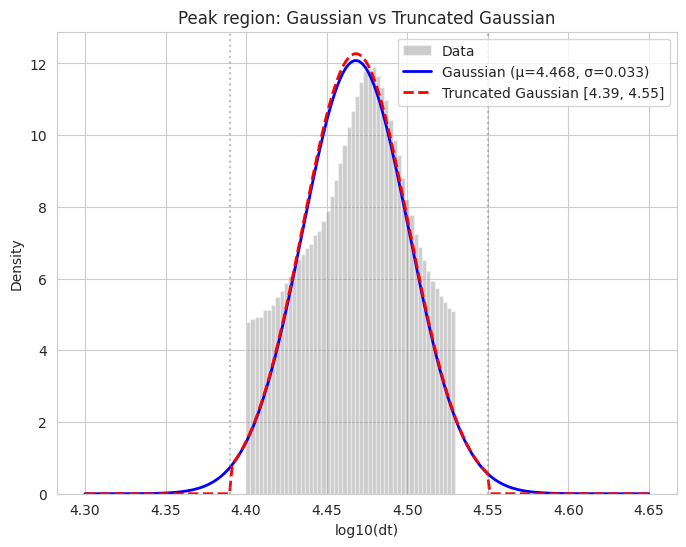

Normal: μ=4.4681, σ=0.0330


In [34]:
peak_data = dt["dt_log"].filter(
  (dt["dt_log"] > 4.4) & (dt["dt_log"] < 4.53)
).to_numpy()

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(peak_data, bins=50, density=True, alpha=0.4, color='gray', label='Data')

x = np.linspace(4.3, 4.65, 200)

# Fit normal
mu, sigma = stats.norm.fit(peak_data)
ax.plot(x, stats.norm.pdf(x, mu, sigma), 'blue', lw=2, label=f'Gaussian (μ={mu:.3f}, σ={sigma:.3f})')

# Truncated normal to [4.39, 4.55]
a, b = 4.39, 4.55
a_std, b_std = (a - mu) / sigma, (b - mu) / sigma
ax.plot(x, stats.truncnorm.pdf(x, a_std, b_std, loc=mu, scale=sigma), 'red', lw=2, linestyle='--',
      label=f'Truncated Gaussian [{a}, {b}]')

ax.axvline(a, color='gray', linestyle=':', alpha=0.5)
ax.axvline(b, color='gray', linestyle=':', alpha=0.5)
ax.legend()
ax.set_xlabel("log10(dt)")
ax.set_ylabel("Density")
ax.set_title("Peak region: Gaussian vs Truncated Gaussian")
plt.savefig("../figures/peak_fit.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Normal: μ={mu:.4f}, σ={sigma:.4f}")


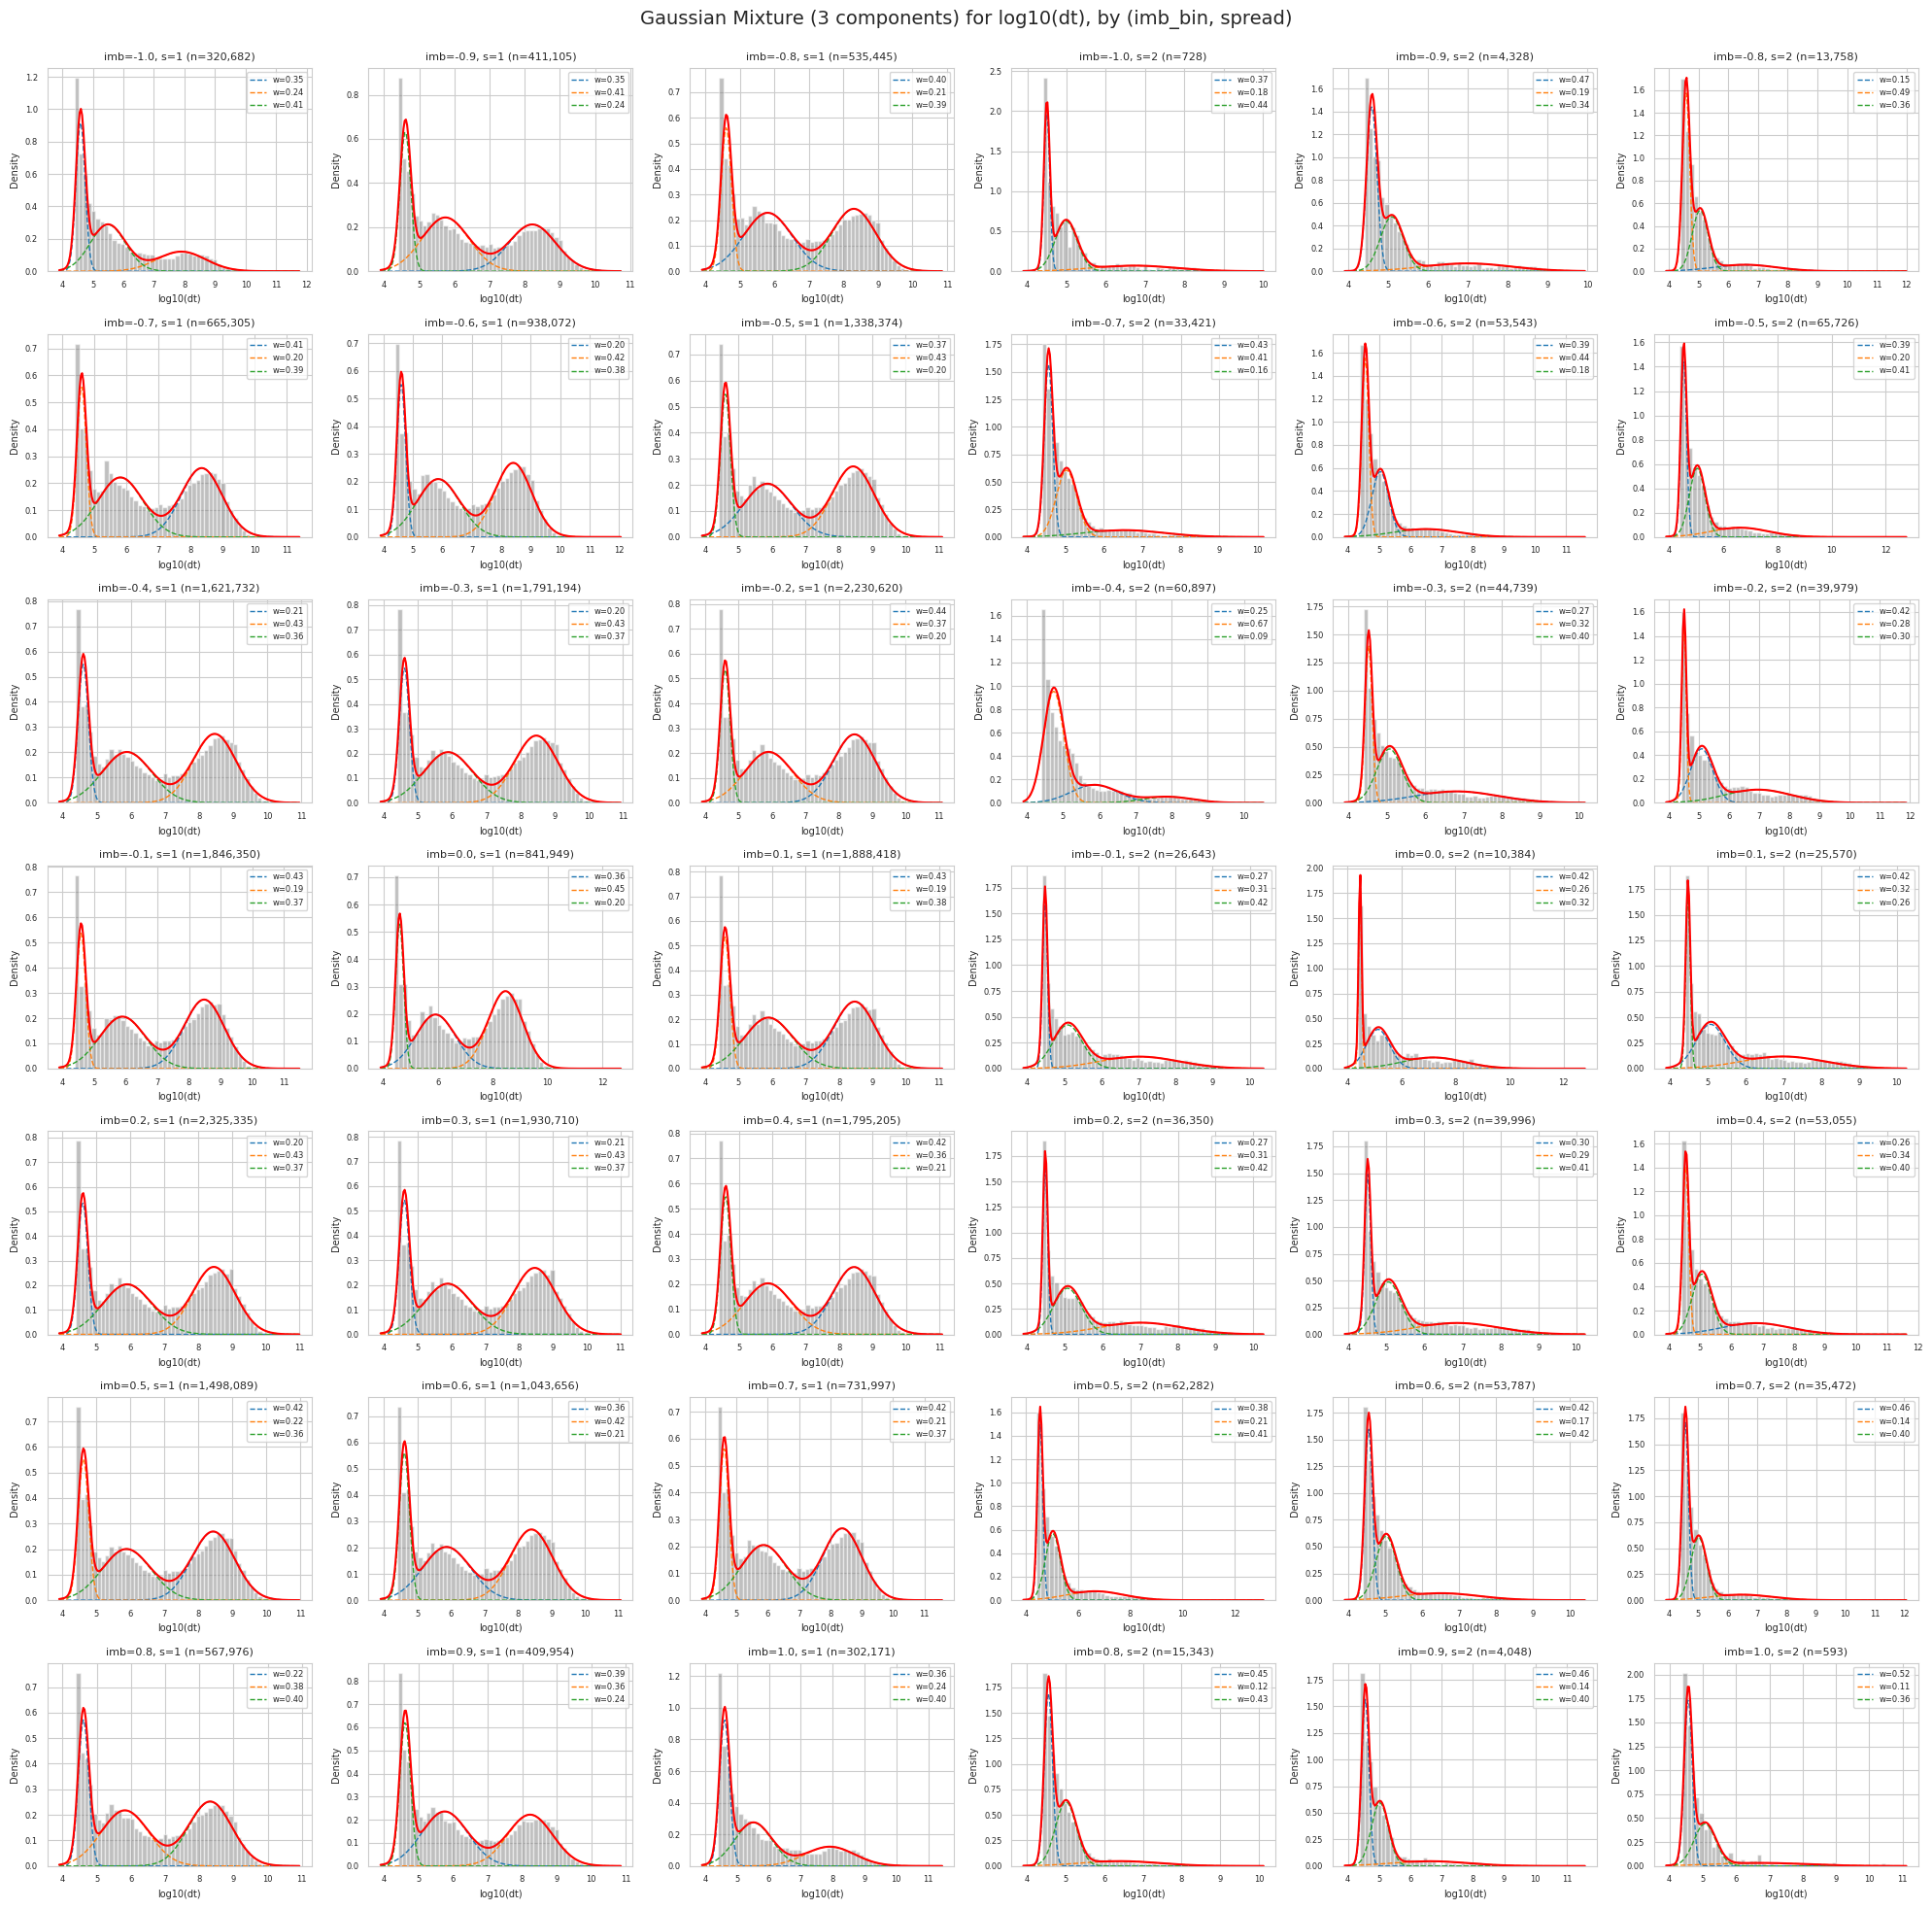

In [11]:
dt_filtered = dt.filter(pl.col("dt_log").gt(4.4))

# Get unique imbalance bins and spreads
imb_bins = sorted(dt_filtered["imb_bin"].unique().to_list())
spreads = sorted(dt_filtered["spread"].unique().to_list())

# Create figure with 21x2=42 subplots (7 rows x 6 cols, 3 per spread)
fig, axes = plt.subplots(7, 6, figsize=(20, 20))

# Fit GMM for each (imb_bin, spread) pair
gmm_params = []

for i, imb_bin in enumerate(imb_bins):
  for j, spread in enumerate(spreads):
      # Column: spread=1 uses cols 0,1,2; spread=2 uses cols 3,4,5
      col = (i % 3) + (j * 3)
      row = i // 3
      ax = axes[row, col]

      # Get data for this (imb_bin, spread) pair
      data = dt_filtered.filter(
          (pl.col("imb_bin").eq(imb_bin)) & (pl.col("spread").eq(spread))
      )["dt_log"].to_numpy()

      if len(data) < 10:
          ax.set_title(f"imb={imb_bin:.1f}, s={spread} (n={len(data)})", fontsize=8)
          ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=ax.transAxes)
          continue

      log_dt = data.reshape(-1, 1)

      # Fit 3-component Gaussian mixture
      gmm = GaussianMixture(n_components=3, random_state=42).fit(log_dt)

      # Extract parameters
      means = gmm.means_.flatten()
      stds = np.sqrt(gmm.covariances_.flatten())
      weights = gmm.weights_

      # Store params (spread as 0 or 1 for C++ indexing)
      gmm_params.append({
          "imb_bin": imb_bin,
          "spread": spread - 1,  # 0 for spread=1, 1 for spread>=2
          "w1": weights[0], "mu1": means[0], "sigma1": stds[0],
          "w2": weights[1], "mu2": means[1], "sigma2": stds[1],
          "w3": weights[2], "mu3": means[2], "sigma3": stds[2],
          "n": len(data)
      })

      # Plot
      x = np.linspace(log_dt.min() - 0.5, log_dt.max() + 0.5, 200)
      pdf1 = weights[0] * stats.norm.pdf(x, means[0], stds[0])
      pdf2 = weights[1] * stats.norm.pdf(x, means[1], stds[1])
      pdf3 = weights[2] * stats.norm.pdf(x, means[2], stds[2])
      pdf_mix = pdf1 + pdf2 + pdf3

      ax.hist(log_dt, bins=50, density=True, alpha=0.5, color="gray")
      ax.plot(x, pdf1, "--", lw=1, label=f"w={weights[0]:.2f}")
      ax.plot(x, pdf2, "--", lw=1, label=f"w={weights[1]:.2f}")
      ax.plot(x, pdf3, "--", lw=1, label=f"w={weights[2]:.2f}")
      ax.plot(x, pdf_mix, "r-", lw=1.5)
      ax.set_title(f"imb={imb_bin:.1f}, s={spread} (n={len(data):,})", fontsize=8)
      ax.legend(fontsize=6, loc="upper right")
      ax.set_xlabel("log10(dt)", fontsize=7)
      ax.set_ylabel("Density", fontsize=7)
      ax.tick_params(labelsize=6)

plt.suptitle("Gaussian Mixture (3 components) for log10(dt), by (imb_bin, spread)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig("../figures/mixture_fit.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

params_df = pl.DataFrame(gmm_params)


In [12]:
# params_df.write_csv("../data/AAL2/delta_t_mixtures_floored.csv")

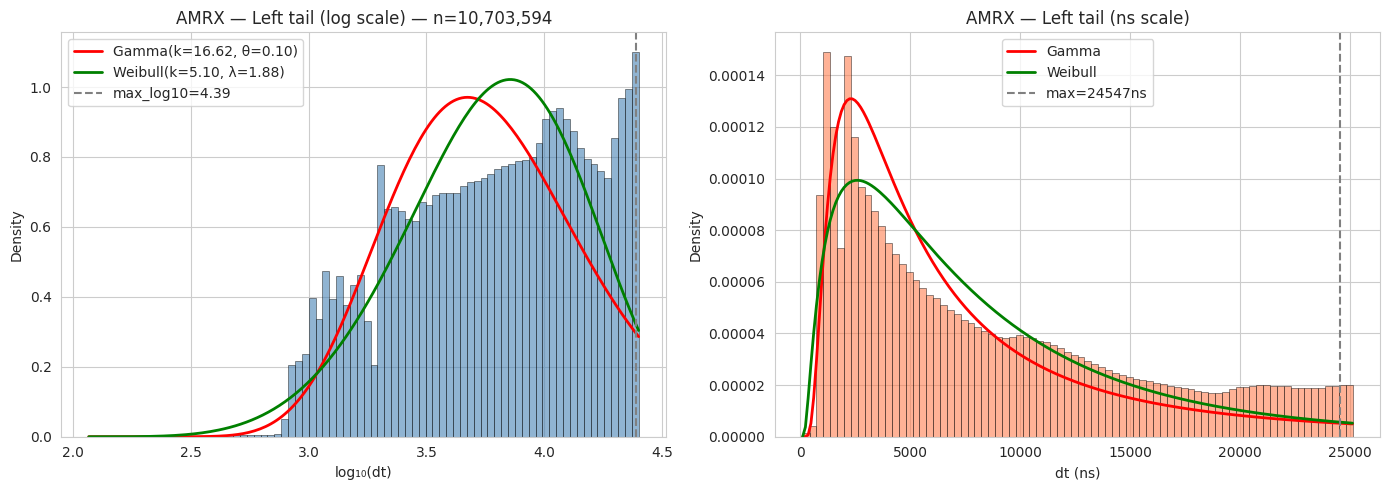

Log-likelihood: Gamma=-5728918.8, Weibull=-5150845.0

Gamma:   k=16.6189, θ=0.1035
Weibull: k=5.1026, λ=1.8758
Shift:   2.0582


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

left_tail = dt.filter(pl.col("dt_log").lt(4.4))["dt_log"].to_numpy()
# Shift data for fitting (both require x > 0)
shift_val = left_tail.min() - 0.01
left_tail_shifted = left_tail - shift_val

# Fit Gamma and Weibull
a_gamma, _, scale_gamma = stats.gamma.fit(left_tail_shifted, floc=0)
c_weibull, _, scale_weibull = stats.weibull_min.fit(left_tail_shifted, floc=0)

# Left plot: log10 space
ax = axes[0]
ax.hist(left_tail, bins=80, alpha=0.6, color='steelblue', edgecolor='black', linewidth=0.5, density=True)
x_log = np.linspace(left_tail.min(), left_tail.max(), 200)
x_shifted = x_log - shift_val
ax.plot(x_log, stats.gamma.pdf(x_shifted, a_gamma, loc=0, scale=scale_gamma), 'r-', lw=2,
  label=f'Gamma(k={a_gamma:.2f}, θ={scale_gamma:.2f})')
ax.plot(x_log, stats.weibull_min.pdf(x_shifted, c_weibull, loc=0, scale=scale_weibull), 'g-', lw=2,
  label=f'Weibull(k={c_weibull:.2f}, λ={scale_weibull:.2f})')
ax.axvline(4.39, color='gray', linestyle='--', lw=1.5, label='max_log10=4.39')
ax.set_xlabel("log₁₀(dt)")
ax.set_ylabel("Density")
ax.set_title(f"{ticker} — Left tail (log scale) — n={len(left_tail):,}")
ax.legend()

# Right plot: nanoseconds
ax = axes[1]
left_tail_ns = 10**left_tail
ax.hist(left_tail_ns, bins=80, alpha=0.6, color='coral', edgecolor='black', linewidth=0.5, density=True)

x_ns = np.linspace(left_tail_ns.min(), left_tail_ns.max(), 200)
x_log_t = np.log10(x_ns)
x_shifted_t = x_log_t - shift_val

# Transform PDFs: f_Y(y) = f_X(log10(y)) / (y * ln(10))
pdf_gamma_ns = stats.gamma.pdf(x_shifted_t, a_gamma, loc=0, scale=scale_gamma) / (x_ns * np.log(10))
pdf_weibull_ns = stats.weibull_min.pdf(x_shifted_t, c_weibull, loc=0, scale=scale_weibull) / (x_ns * np.log(10))

ax.plot(x_ns, pdf_gamma_ns, 'r-', lw=2, label='Gamma')
ax.plot(x_ns, pdf_weibull_ns, 'g-', lw=2, label='Weibull')
ax.axvline(10**4.39, color='gray', linestyle='--', lw=1.5, label=f'max={10**4.39:.0f}ns')
ax.set_xlabel("dt (ns)")
ax.set_ylabel("Density")
ax.set_title(f"{ticker} — Left tail (ns scale)")
ax.legend()

plt.tight_layout()
plt.savefig("../figures/tail_fit.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Log-likelihood comparison
ll_gamma = np.sum(stats.gamma.logpdf(left_tail_shifted, a_gamma, loc=0, scale=scale_gamma))
ll_weibull = np.sum(stats.weibull_min.logpdf(left_tail_shifted, c_weibull, loc=0, scale=scale_weibull))

print(f"Log-likelihood: Gamma={ll_gamma:.1f}, Weibull={ll_weibull:.1f}")
print(f"\nGamma:   k={a_gamma:.4f}, θ={scale_gamma:.4f}")
print(f"Weibull: k={c_weibull:.4f}, λ={scale_weibull:.4f}")
print(f"Shift:   {shift_val:.4f}")


In [14]:
# shift_val = left_tail.min()

# pl.DataFrame({
#   "k": [a_gamma],
#   "scale": [scale_gamma],
#   "shift": [shift_val],
#   "max_log10": [4.4]
# }).write_csv("../data/AAL2/gamma_distrib.csv")

# pl.DataFrame({
#   "k": [c_weibull],
#   "scale": [scale_weibull],
#   "shift": [shift_val],
#   "max_log10": [4.4]
# }).write_csv("../data/AAL2/weibull_distrib.csv")


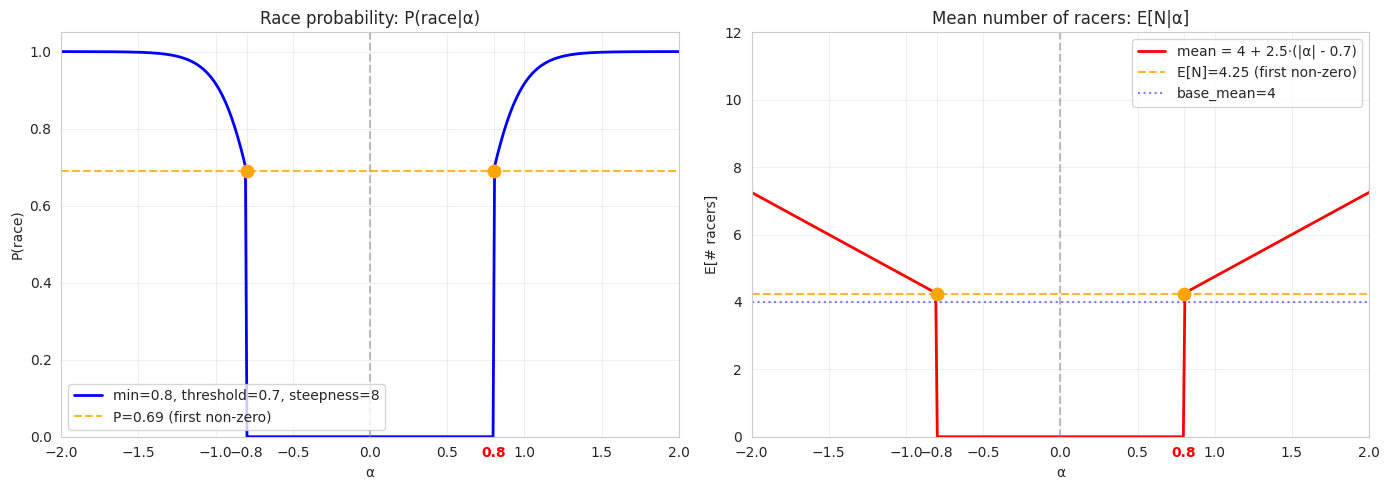

In [15]:
alpha = np.linspace(-2, 2, 400)

def p_logistic_with_min(a, min_thresh=0.8, threshold=0.7, steepness=8):
    p = 1 / (1 + np.exp(-steepness * (np.abs(a) - threshold)))
    p = np.where(np.abs(a) < min_thresh, 0, p)
    return p

def mean_racers(a, base_mean=4.0, racer_scale=2.5, threshold=0.7, min_thresh=0.8):
    abs_a = np.abs(a)
    mean = base_mean + racer_scale * np.maximum(0, abs_a - threshold)
    mean = np.where(abs_a < min_thresh, 0, mean)
    return mean

# First non-zero probability value (at |α| = min_thresh)
first_p = p_logistic_with_min(np.array([0.8]), min_thresh=0.8, threshold=0.7, steepness=8)[0]
first_mean = mean_racers(np.array([0.8]), base_mean=4.0, racer_scale=2.5, threshold=0.7, min_thresh=0.8)[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Race probability
ax = axes[0]
ax.plot(alpha, p_logistic_with_min(alpha, min_thresh=0.8, threshold=0.7, steepness=8),
    'b-', lw=2, label=f"min=0.8, threshold=0.7, steepness=8")

# Highlight first non-zero probability
ax.axhline(first_p, color='orange', linestyle='--', lw=1.5, alpha=0.8, label=f'P={first_p:.2f} (first non-zero)')
ax.scatter([0.8, -0.8], [first_p, first_p], color='orange', s=80, zorder=5)

ax.set_xlabel("α")
ax.set_ylabel("P(race)")
ax.set_xlim(-2, 2)
ax.set_ylim(0, 1.05)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xticks([-2, -1.5, -1, -0.8, -0.5, 0, 0.5, 0.8, 1, 1.5, 2])
ax.tick_params(axis='x', which='major')
for label in ax.get_xticklabels():
  if label.get_text() in ['-0.8', '0.8']:
      label.set_color('red')
      label.set_fontweight('bold')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title("Race probability: P(race|α)")

# Right plot: Mean number of racers
ax = axes[1]
ax.plot(alpha, mean_racers(alpha, base_mean=4.0, racer_scale=2.5, threshold=0.7, min_thresh=0.8),
    'r-', lw=2, label=f"mean = 4 + 2.5·(|α| - 0.7)")

# Highlight first non-zero mean
ax.axhline(first_mean, color='orange', linestyle='--', lw=1.5, alpha=0.8, label=f'E[N]={first_mean:.2f} (first non-zero)')
ax.scatter([0.8, -0.8], [first_mean, first_mean], color='orange', s=80, zorder=5)

ax.set_xlabel("α")
ax.set_ylabel("E[# racers]")
ax.set_xlim(-2, 2)
ax.set_ylim(0, 12)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xticks([-2, -1.5, -1, -0.8, -0.5, 0, 0.5, 0.8, 1, 1.5, 2])
for label in ax.get_xticklabels():
  if label.get_text() in ['-0.8', '0.8']:
      label.set_color('red')
      label.set_fontweight('bold')
ax.axhline(4, color='blue', linestyle=':', alpha=0.5, label='base_mean=4')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title("Mean number of racers: E[N|α]")

plt.tight_layout()
plt.savefig("../figures/race_proba_nb.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
